# Library Imports

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc import math as pm_math
from scipy.stats import halfnorm, skewnorm

# Model Specification
## Simulated Data
$$ X \sim N(1,1) $$
$$ U \sim HN(0, \sigma_u^2) $$
$$ Y \sim SN(\xi, \sigma_v^2, \lambda)$$
$$ \xi = \alpha + \beta X - U $$
$$ \alpha = 5, \beta = 2 $$
## Priors
$$ \alpha \sim N(\mu_\alpha, \sigma_\alpha^2) $$
$$ \beta \sim N(\mu_\beta, \sigma_\beta^2) $$
$$ \sigma_v^2 \sim IG(\alpha_v, \beta_v) $$
$$ \sigma_u^2 \sim IG(\alpha_u, \beta_u) $$
$$ \lambda \sim TN(\mu_\lambda, \sigma_\lambda^2; a, b)$$


# Simulate Data

In [2]:
np.random.seed(123)

# Parameters 
n = 50
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -0.5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

In [3]:
data.head()

,X,Y
0,-0.085631,3.444481
1,1.997345,6.248438
2,1.282978,3.450195
3,-0.506295,-1.071731
4,0.421400,7.164607


In [ ]:
with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.HalfNormal('sigma_u', sigma=1)
    sigma_v = pm.HalfNormal('sigma_v', sigma=1.5)
    lam = pm.Normal('lam', mu=-5, sigma=5)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.99, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.28,0.95,1.68,5.15,0.03,0.02,1366.60,2030.68,1.00
beta,2.33,0.18,2.00,2.69,0.00,0.00,5939.14,5299.73,1.00
lam,1.48,2.31,-2.00,5.91,0.12,0.06,398.74,1416.09,1.00
sigma_u,0.98,0.58,0.00,1.89,0.05,0.01,152.92,200.98,1.02
sigma_v,1.74,0.33,1.18,2.37,0.01,0.00,1843.29,2486.83,1.00
U[0],0.60,0.59,0.00,1.72,0.02,0.01,389.53,745.63,1.00
U[1],1.10,0.93,0.00,2.73,0.06,0.01,200.14,294.90,1.01
U[2],1.51,1.24,0.00,3.59,0.09,0.02,180.46,314.66,1.01
U[3],1.63,1.34,0.00,3.88,0.10,0.02,180.97,342.94,1.01
U[4],0.40,0.42,0.00,1.17,0.01,0.01,506.27,870.02,1.00


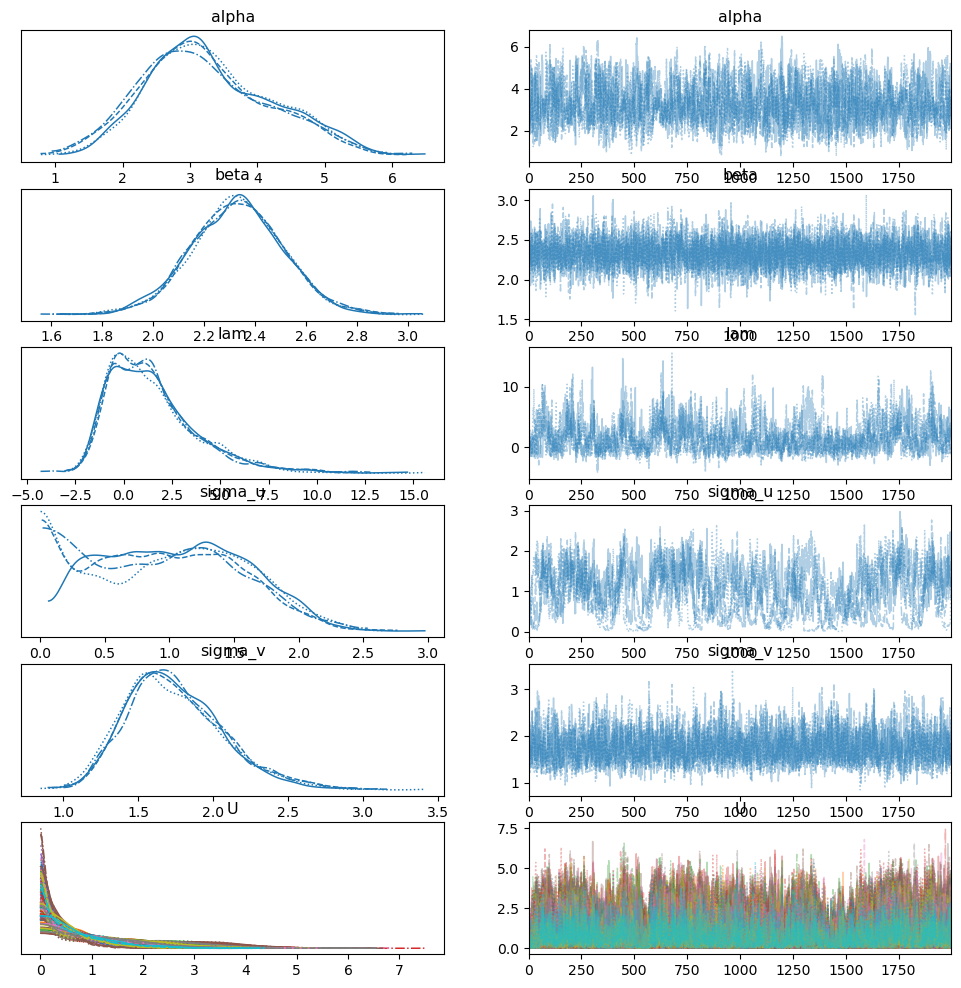

In [5]:
az.plot_trace(trace)
az.summary(trace, round_to=2)